# Agentic RAG System using Amazon Bedrock Knowledge Bases and LangGraph

This notebook implements a self-corrective RAG (Retrieval-Augmented Generation) workflow using LangGraph for orchestration. The system uses several advanced techniques to improve answer accuracy:

1. **Query expansion** - Looks up domain terms to transform queries with added context
2. **Context relevance checking** - Evaluates if retrieved documents are relevant to the query
3. **Query decomposition** - Breaks down complex questions when needed
4. **Self-correction** - Evaluates response quality and relevance, taking corrective action if needed

## Setup

#### Self corrective RAG workflow using query expansion and decomposition as techniques to optimize the accuray

<!-- <img align=center, src="SelfCorrectiveRAG.png"> -->

<!-- <div style="width: 1150px; height: 580px; position: relative;"><img allowfullscreen style="width:1150px; height:580px" src="SelfCorrectiveRAG.png"></div> -->

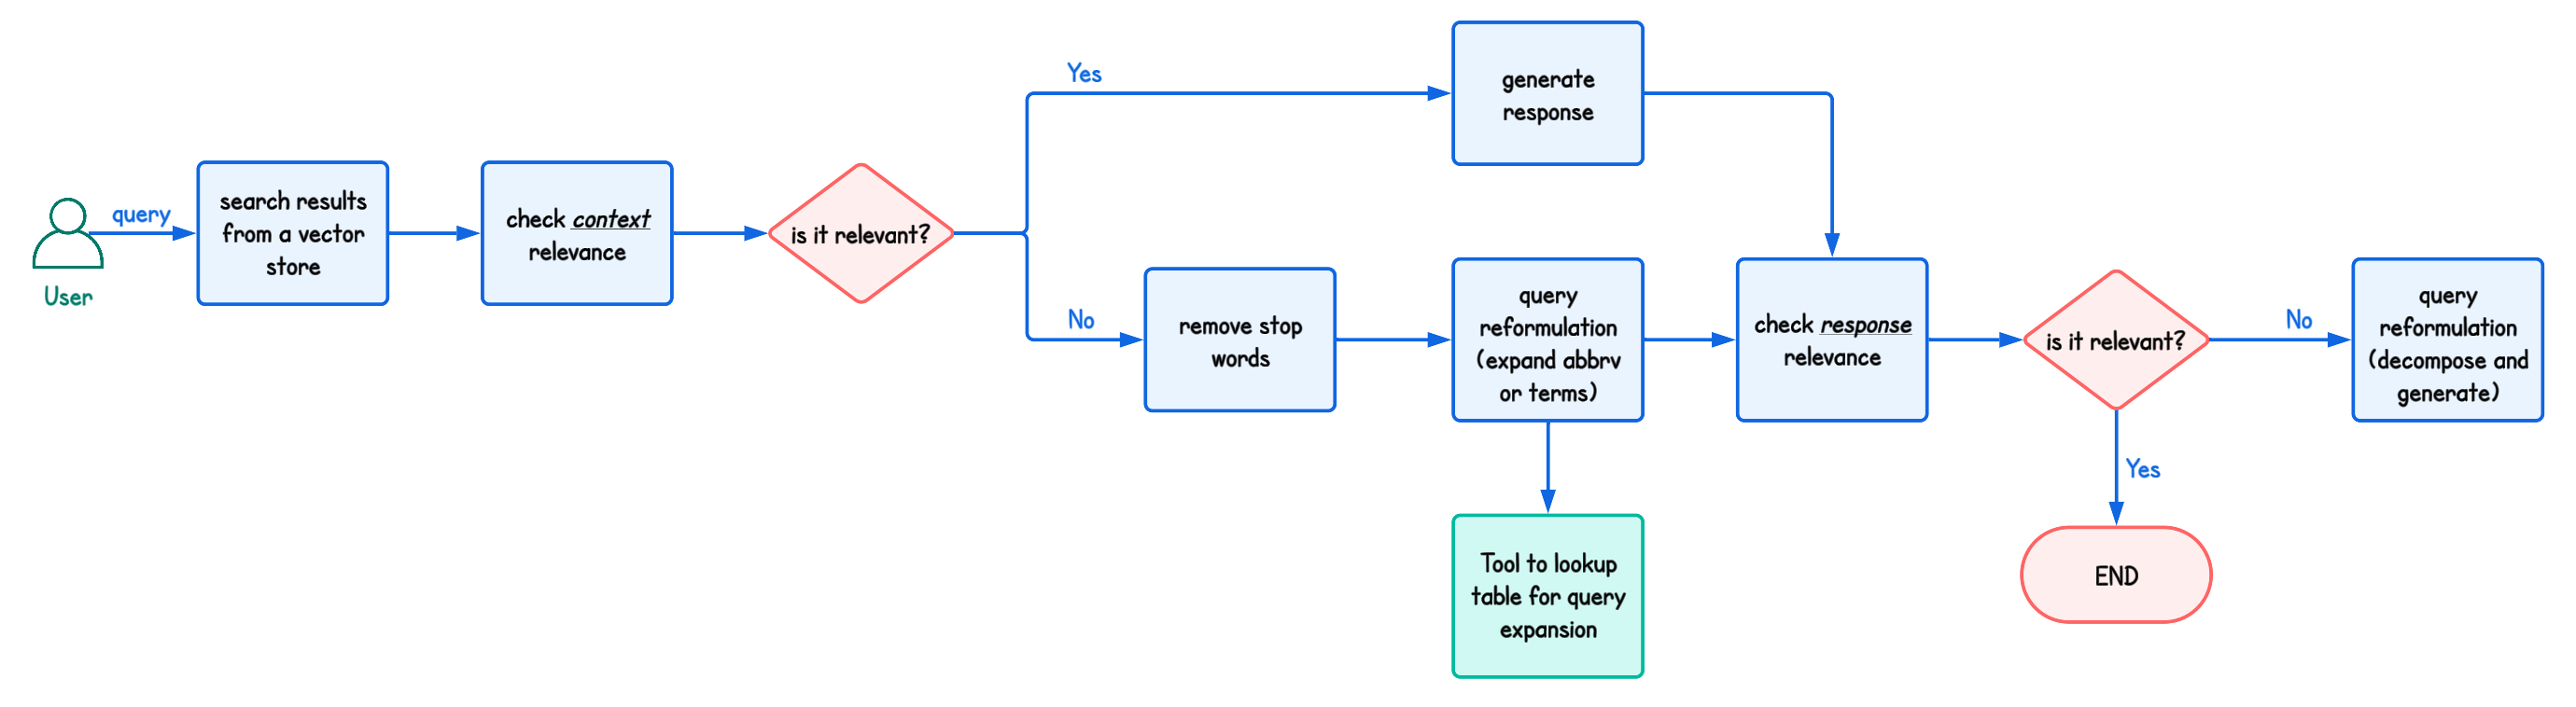

## Pre-requisites
1. Run notebook 1 (01-setup-create-insert-dynamodb.ipynb) to create and populate the DynamoDB table, with sample lookup data. 

## Import Stored Variables

Retrieve the DynamoDB table name from the previous notebook using Jupyter's `%store -r` magic command.

In [ ]:
%store -r table_name

## Install Required Libraries

Install necessary packages for implementing the RAG system:
- langchain and related modules for building LLM applications
- NLTK for natural language processing tasks
- RAGAS for evaluation metrics

In [ ]:
%%capture --no-stderr
%pip install --force-reinstall -q -r ../../features-examples/requirements.txt
%pip install --force-reinstall -q ragas

NOTE: Make sure to manually restart the notebook after installing packages.

In [ ]:
# # restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Import Libraries and Set Up Logging

Import necessary libraries:
- boto3 for AWS services
- langgraph components for building the workflow
- Other utility libraries for handling asynchronous operations, logging, etc.

Also configure logging to track workflow execution.

In [ ]:
import boto3
import json, sys
from datetime import datetime
import json
import time
import boto3
import asyncio
import logging
import inspect
from typing import List
from langgraph.graph import END, StateGraph, START

logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
print('Running boto3 version:', boto3.__version__)

## Configure Amazon Bedrock Services

Set up the Amazon Bedrock services:
1. Choose the foundation model (Claude 3 Sonnet in this case)
2. Configure the AWS region
3. Initialize Bedrock clients (runtime and agent-runtime)
4. Set the Knowledge Base ID for RAG retrieval

In [ ]:
# Model configurations (used for query expansion)

modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'
#modelId = 'anthropic.claude-3-haiku-20240307-v1:0'
#modelId = 'cohere.command-r-plus-v1:0'
#modelId = 'cohere.command-r-v1:0'
#modelId = 'mistral.mistral-large-2402-v1:0'
print(f'Using modelId: {modelId}')

## Set up for creating a Knowledge Base

In [ ]:
import os
import sys
import time
import boto3
import logging
import pprint
import json

# Set the path to import utils module
from pathlib import Path
current_path = Path().resolve()
current_path = str(current_path.parent.parent)  + "/features-examples"
if str(current_path) not in sys.path:
    sys.path.append(str(current_path))
# Print sys.path to verify
# print(sys.path)

from utils.knowledge_base import BedrockKnowledgeBase

#Clients
s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
session = boto3.session.Session()
region =  session.region_name
account_id = sts_client.get_caller_identity()["Account"]
bedrock = boto3.client(
    service_name = 'bedrock-runtime',
    region_name = region,
    )
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime') 
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
region, account_id

In [ ]:
import time

# Get the current timestamp
current_time = time.time()

# Format the timestamp as a string
timestamp_str = time.strftime("%Y%m%d%H%M%S", time.localtime(current_time))[-7:]
# Create the suffix using the timestamp
suffix = f"{timestamp_str}"

knowledge_base_name = f"bedrock-kb-corrective-rag-{suffix}"
knowledge_base_description = "Octank financial data with s3 as data source."

bucket_name = f'{knowledge_base_name}-{account_id}'

data_bucket_name = f'bedrock-kb-{suffix}-1' # replace it with your first bucket name.

data_sources=[{"type": "S3", "bucket_name": data_bucket_name}]
                
pp = pprint.PrettyPrinter(indent=2)

### Creating Knowledge Base

In [ ]:
knowledge_base = BedrockKnowledgeBase(
    kb_name=f'{knowledge_base_name}',
    kb_description=knowledge_base_description,
    data_sources=data_sources,
    chunking_strategy = "FIXED_SIZE", 
    suffix = f'{suffix}-f'
)

#### Upload data to S3 Bucket data source

In [ ]:
def upload_directory(path, bucket_name):
    for root, dirs, files in os.walk(path):
        for file in files:
            file_to_upload = os.path.join(root, file)
            if file not in ["LICENSE", "NOTICE", "README.md", "podcastdemo.mp3","bda.m4v"]:
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload, bucket_name, file)
            else:
                print(f"Skipping file {file_to_upload}")

upload_directory(sys.path[-1]+"/synthetic_dataset", data_bucket_name)

### Start ingestion job
Once the KB and data source(s) created, we can start the ingestion job for each data source.
During the ingestion job, KB will fetch the documents in the data source, pre-process it to extract text, chunk it based on the chunking size provided, create embeddings of each chunk and then write it to the vector database, in this case OSS.

NOTE: Currently, you can only kick-off one ingestion job at one time.

In [ ]:
# ensure that the kb is available
time.sleep(30)
# sync knowledge base
knowledge_base.start_ingestion_job()

In [ ]:
# keep the kb_id for invocation later in the invoke request
kb_id = knowledge_base.get_knowledge_base_id()
%store kb_id

##  LangGraph for orchestrating the self-corrective RAG workflow

## Define Graph State

Create a `TypedDict` class that defines the graph state:
- `table_name`: DynamoDB table for term lookups
- `question`: The original user query
- `transformed_query`: The query after expansion or transformation
- `response`: The generated answer
- `terms`: Extracted terms from the query
- `checkpoint`: Tracking progress through the workflow
- `documents`: Retrieved context documents
- `context_relevance_score`: Evaluation of document relevance
- `hallucination_score`: Evaluation of response accuracy

Initialize the LangGraph workflow with this state structure.

In [ ]:
# define graph state 
from typing import Dict, TypedDict, Optional, List
from langgraph.graph import StateGraph

class GraphState(TypedDict):
    table_name: Optional[str] = None
    question: Optional[str] = None
    transformed_query: Optional[str] = None
    response: Optional[str] = None
    terms: Optional[List[str]] = None
    checkpoint: int = 0
    documents: Optional[List[str]] = None
    context_relevance_score: Optional[str] = "no"
    hallucination_score: Optional[str] = "no"

workflow = StateGraph(GraphState)

## Define Search Results Node

This node retrieves documents from the knowledge base:
1. Takes either the original question or transformed query based on checkpoint state
2. Calls Bedrock's retrieve API to get relevant documents
3. Updates the state with retrieved context documents

In [ ]:
# given a question, first node will be to fetch the search results
def search_results(state):
    print("---Search results---")
    question = state["question"]
    checkpoint = state["checkpoint"]
    if checkpoint != 0:
        question = state["transformed_query"]
    response = bedrock_agent_runtime_client.retrieve(
        knowledgeBaseId=kb_id,
        retrievalQuery={
            'text': question
        }
    )
    contexts = []
    for context in response["retrievalResults"]:
        contexts.append(context['content']['text'])
    return {"documents": contexts}

## Define Evaluation Nodes

Two evaluation nodes are defined:

1. `check_context_relevance`: 
   - Evaluates whether retrieved documents are relevant to the question
   - Uses foundation model to grade document relevance with a binary yes/no
   - Updates the state with the relevance score

2. `check_response_relevancy`:
   - Evaluates whether the generated response fully answers the question
   - Uses RAGAS metrics with LangChain wrapper for evaluation
   - Returns a binary yes/no score based on a threshold
   - Updates the state with the relevance score

In [ ]:
# node to grade documents
from langchain_aws import ChatBedrockConverse, BedrockEmbeddings
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from ragas import SingleTurnSample 
from ragas.metrics import ResponseRelevancy
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import LLMContextPrecisionWithoutReference

llm_for_evaluation = ChatBedrockConverse(model_id=modelId)
llm_for_evaluation = LangchainLLMWrapper(llm_for_evaluation)
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")
bedrock_embeddings = LangchainEmbeddingsWrapper(bedrock_embeddings)


def check_context_relevance(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK CONTEXT RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatBedrockConverse(model_id=modelId)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are an expert in grading the relevance of search results or retrieved document to a user question.\n
        Your task is to critically analyze and grade the search results.
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the search results or retrieved document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        Also check if context covers the entire question before providing the score.""", 
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    checkpoint = state["checkpoint"]
    if checkpoint != 0:
        question = state["transformed_query"]
    else:
        question = state["question"]

    docs = state["documents"]

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    return {"context_relevance_score":score}

    
async def check_response_relevancy(state):
    """
    Determines whether the answer is relevant and completely answers the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the answer is relevant and completely answers the question
    """
    print("CHECK RESPONSE RELEVANCE")
    response = state["response"]
    docs = state["documents"]
    checkpoint = state["checkpoint"]
    print("------- CHECKPOINT ------", checkpoint)
    if checkpoint !=0: 
        question = state["transformed_query"]
    else: 
        question = state["question"]
    
    sample = SingleTurnSample(
            user_input=question,
            response=response,
            retrieved_contexts= docs, 
        )
    
    
    scorer = ResponseRelevancy(llm = llm_for_evaluation, embeddings = bedrock_embeddings)
    score_result = await scorer.single_turn_ascore(sample)
    print("--------- response relevance result ----------", score_result)
    if score_result > 0.5:
        score = "yes"
    else: 
        score = "no"
    return {"response":response, "response_relevance_score":score}

## Define Conditional Edge Functions

These functions determine the flow between nodes in the graph:

1. `decision_to_generate`:
   - Routes to the generate node if context is relevant 
   - Routes to the remove_stop_words node for query expansion if context is not relevant

2. `decision_decompose_generate`:
   - Routes to END if the response is relevant and complete
   - Routes to decompose_and_generate if the response needs improvement

In [ ]:
# conditional edge
def decision_to_generate(state)-> Literal["generate", "remove_stop_words"]:
    score = state["context_relevance_score"]
    if score == "yes":
        return "generate"
    else:
        return "remove_stop_words"

def decision_decompose_generate(state)-> Literal["decompose_and_generate", END]:
    score = state["response_relevance_score"]
    if score == "yes":
        return END
    else:
        return "decompose_and_generate"

## Define Generate Node

The generate node:
1. Takes either the original question or transformed query based on checkpoint state
2. Calls Bedrock's retrieve_and_generate API to get an answer using RAG
3. Updates the state with the generated response

In [ ]:
# define generate node
def generate(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL GENERATE---")
    checkpoint = state["checkpoint"]
    if checkpoint != 0:
        question = state["transformed_query"]
    else: 
        question = state["question"]
        
    print("user input: ", question)
    print("------- CHECKPOINT ------", checkpoint)
    response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": question
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, modelId),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":5
                }}}})
    result = response['output']['text']
    return {"response": result}

## Define Decompose and Generate Node

This node is used when regular generation fails to produce a satisfactory answer:
1. Uses the same input as the generate node
2. Activates query decomposition in Bedrock's retrieve_and_generate API
3. The decomposition breaks down complex questions into simpler ones
4. Updates the state with the improved response

In [ ]:
# adding another node to perform query decomposition if hallucination occurs.
def decompose_and_generate(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL DECOMPOSE AND GENERATE---")
    checkpoint = state["checkpoint"]
    if checkpoint != 0:
        question = state["transformed_query"]
    else: 
        question = state["question"]
        
    print("user input: ", question)
    print("------- CHECKPOINT ------", checkpoint)
    response = bedrock_agent_runtime_client.retrieve_and_generate(
        input={
            "text": question
        },
        retrieveAndGenerateConfiguration={
            "type": "KNOWLEDGE_BASE",
            "knowledgeBaseConfiguration": {
                'knowledgeBaseId': kb_id,
                "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, modelId),
                "retrievalConfiguration": {
                    "vectorSearchConfiguration": {
                        "numberOfResults":5
                    } 
                },
                'orchestrationConfiguration': {
                    'queryTransformationConfiguration': {
                        'type': 'QUERY_DECOMPOSITION'
                    }
                }
            }
        }
    )
    result = response['output']['text']
    return {"response": result}

## Define Query Preprocessing Nodes

This workflow stage handles query transformation:

1. `remove_stop_words`: 
   - Extracts meaningful terms from the user's question
   - Removes common stop words using NLTK
   - Updates the state with the extracted terms for lookup to DynamoDB table

In [ ]:
# Question pre-processing nodes for query expansion workflow
# first node to remove stop words from a question.
import re
from nltk.corpus import stopwords

def remove_stop_words(state):
    question = state["question"]
    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\w+', question.lower())
    filtered_words = [word for word in words if word not in stop_words]
    return {"terms": filtered_words}

## Define Term Lookup Tool

Creates a tool class for looking up terms in the DynamoDB table:
- Defines a `lookup_term` method to retrieve term definitions
- Takes a term and table name as input
- Returns the definition if found, empty string if not
- Handles errors gracefully

In [ ]:
# Tool to lookup terms in DynamoDB and return a dictionary of terms and corresponding definitions
from langchain.tools import BaseTool, StructuredTool, tool

class ToolsList:
    # Define our lookup_term tool function
    def lookup_term(self, term, table_name):
        
        dynamodb = boto3.resource('dynamodb')
        table = dynamodb.Table(table_name)

        try:
            response = table.get_item(
                Key={
                    'term': term.lower(),
                },
                ProjectionExpression='term_definition'
            )
        except Exception as e:
            print(f"Error looking up term '{term}': {e}")
            return None

        if 'Item' in response:
            definition = response['Item'].get('term_definition')
            print(f'Tool result: {definition}')
            return definition
        else:
            print(f"Term '{term}' not found in the table.")
            return " "

## Define Query Expansion Node

This complex node implements function calling with Bedrock to expand queries:

1. The `converse_with_tools` function:
   - Configures the lookup_term tool for Claude's function calling using Amazon Bedrock Converse API
   - Handles the conversation flow with the model

2. Helper functions for processing function calls:
   - `call_function`: Executes each tool call
   - `async_call_function`: Wraps function calls for asynchronous execution
   - `async_call_all_functions`: Manages concurrent batch processing of function calls

3. The main `query_expansion` function:
   - Orchestrates the entire query expansion process
   - Uses Claude to identify terms to look up in the DynamoDB
   - Processes tool responses to get term definitions
   - Transforms the original query using the definitions
   - Returns an improved, context-enriched query

In [ ]:
# helper function to call lookup tool. 
def converse_with_tools(messages, system=''):
    # toolConfig for lookup terms
    # Define the configuration for our tool
    print(messages)
    toolConfig = {'tools': [],
    'toolChoice': {
        'auto': {},
        }
    }

    toolConfig['tools'].append({
        'toolSpec': {
            'name': 'lookup_term',
            'description': 'Look up the definition of a term in a DynamoDB table.',
            'inputSchema': {
                'json': {
                    'type': 'object',
                    'properties': {
                        'term': {
                            'type': 'string',
                            'description': 'The term to look up'
                        },
                        'table_name': {
                            'type': 'string',
                            'description': 'The name of the DynamoDB table'
                        }
                    },
                    'required': ['term', 'table_name']
                }
            }
        }
    })
    
    response = bedrock.converse(
        modelId=modelId,
        inferenceConfig={
            "temperature": 0,
            "maxTokens": 4000
        },
        system=system,
        messages=messages,
        toolConfig=toolConfig
    )
    return response

# helper function on iterating through the look_up terms: 
def call_function(function, tool_class):
    logger.info(f"function={function}")
    function = function[1]
    logger.info(f"step 2, function - Calling tool...{function['name']}")
    tool_name = function['name']
    tool_args = function['input'] or {}
    tool_response = getattr(tool_class, tool_name)(**tool_args)
    logger.info(f"step 2, function {function['name']}- Got tool response...{tool_response}")
    return dict(tool_response=tool_response, tool_use_id=function['toolUseId'])

# Asynchronous wrapper function to allow our function calls to happen concurrently
async def async_call_function(function, tool_class):
    # Run the call_function function in a separate thread to run each function asynchronously
    return await asyncio.to_thread(call_function, function, tool_class)

# Final asynchronous function to deploy all of the functions concurrently
async def async_call_all_functions(function_calling, tool_class):
    
    n: int = 4 # max concurrency so as to not get a throttling exception
    
    ## Split experiments into smaller batches for concurrent deployment
    function_calling_splitted = [function_calling[i * n:(i + 1) * n] for i in range((len(function_calling) + n - 1) // n )]
    results = []
    for function_sublist in function_calling_splitted:
        ## do the function calls in batches
        result = await asyncio.gather(*[async_call_function(function, 
                                                            tool_class) for function in enumerate(function_sublist)])
        ## Collect and furthermore extend the results from each batch
        results.extend(result)
    return results

# Function for orchestrating the conversation flow
# this will be used as a node. 
async def query_expansion(state):

    """
    This function uses function call to answer uses questions in 3 steps
    1. Ask the LLM what to do given the user question and the tools provided.
    2. Read the LLM response and if the response says use this tool(s) then invoke the
       function(s) corresponding to that tool.
       - If the LLM says no tool use is required/available then return that as the final 
         response
    3. Provide the entire conversation history including the function call output to the LLM
       and ask for a response.
    4. Repeat steps 2 and 3 until the LLM response says no more tools need to be used, return
       that as the final response.   
    """
    prompt = state["question"]
    extracted_terms = state["terms"]
    system = [{"text": f"""You're provided a tool named 'lookup_term' to transform or reformulate the user question.
                    You can call the tool multiple times in the same response if required.
                    'lookup_term' tool can be used to return the definition of the following comma separated term(s).
                    <terms>
                    [{extracted_terms}]
                    </terms>
                    Call the tool 'lookup_term' for each term.
                    Only use the return values of this tool to get the definition of the term.
                    use the term definitions and the question to transform the question with meaningful information.
                    DO NOT change the meaning of the original question.
                    If no value is returned by tool, return the original question as-is.
                    Make sure the final output is the single transformed question only.
                    Use table_name as {table_name} if using the tool for lookup.
                    Don't make reference to the tools in your final answer.
                      Output format:
                      DO NOT add any preamble to the output such as The transformed question is:
                      Output should only include the transformed question.
                      Don't make reference to the tools in your final answer.
                      DO NOT answer the question, only provide transformed question as final output.
                   """}]
    
    # step 1. invoke model for the first time to figure out what tools if any are needed
    messages = [{"role": "user", "content": [{"text": prompt}]}]
    logger.info(f"step 1. Invoking model...{modelId}")
    output = converse_with_tools(messages, system)
    messages.append(output['output']['message'])
    logger.info(f"step 1 output from model...{json.dumps(output['output'], indent=2, default=str)}")

    while True:
        # step 2. check if the model said any tools should be used, invoke the tools that the model
        # said need to be used

        function_calling = [c['toolUse'] for c in output['output']['message']['content'] if 'toolUse' in c]
        if function_calling:
            tool_result_message = {"role": "user", "content": []}
            logger.info(f"there are {len(function_calling)} entries in function_calling")
            # async version
            s = time.perf_counter()

            # Call all functions in parallel
            tool_responses_list = await async_call_all_functions(function_calling, tool_class=ToolsList())
            elapsed_async = time.perf_counter() - s
            logger.info(f"ran {len(function_calling)} in parallel in {elapsed_async:0.4f} seconds")
            for r in tool_responses_list:
                tool_result_message['content'].append({
                    'toolResult': {
                        'toolUseId': r['tool_use_id'],
                        'content': [{"text": r['tool_response']}]
                    }
                })
            messages.append(tool_result_message)
        else:
            logger.info(f"there are NO functions to call as per the LLM")
            break

        # step 3. call the model one final time to put all the tool responses together
        # and generate a final response
        logger.info(f"step 3, calling model with the results from calling {len(function_calling)} functions")
        
        output = converse_with_tools(messages, system)
        messages.append(output['output']['message'])
        logger.info(f"function calling - Got final answer from step 3, checking if more function calling is needed")
        function_calling = [c['toolUse'] for c in output['output']['message']['content'] if 'toolUse' in c]
        response = output['output']['message']['content'][0].get('text')
        if len(function_calling) == 0:
            logger.info(f"step 3. no more function calling is needed, we have our final answer, exiting")
            break
        else:
            logger.info(f"step 3. seems like we still need to call {len(function_calling)} functions, continuing..")
        
    return {"transformed_query": response, "checkpoint": 1}

## Assemble and Compile the Graph

Now we define the graph structure:
1. Add all the defined nodes to the graph
2. Create edges between nodes to establish the workflow
3. Add conditional edges with decision functions for dynamic routing
4. Compile the final graph for execution

In [ ]:
# Define a new graph
workflow = StateGraph(GraphState)
# define nodes
workflow.add_node("search_results", search_results)
workflow.add_node("check_context_relevance", check_context_relevance)
workflow.add_node("generate", generate) 
workflow.add_node("remove_stop_words", remove_stop_words)
workflow.add_node("query_expansion", query_expansion)
workflow.add_node("check_response_relevance", check_response_relevancy) 
workflow.add_node("decompose_and_generate", decompose_and_generate)
#define edges
workflow.add_edge(START, "search_results")
workflow.add_edge("search_results", "check_context_relevance")
workflow.add_edge("remove_stop_words", "query_expansion")
workflow.add_edge("query_expansion", "generate")
workflow.add_edge("generate", "check_response_relevance")
workflow.add_conditional_edges(
    "check_context_relevance",
    # Assess agent decision
    decision_to_generate,
)
workflow.add_conditional_edges(
    "check_response_relevance",
    # Assess agent decision
    decision_decompose_generate,
)
workflow.add_edge("decompose_and_generate", END)

# Compile
graph = workflow.compile()

## Visualize the Graph

Generate and display a visual representation of the workflow graph showing:
- All nodes in the workflow
- Connections between nodes
- Conditional paths in the workflow

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Test with sample questions

In the flow diagram, refer to the `green lines` for each case. 


## Case 1: Basic Workflow Example 

This example demonstrates the normal flow of the RAG workflow:
1. A query about the fair value of the HTM portfolio is submitted
2. Documents are retrieved and determined to be relevant
3. A response is generated directly without needing query expansion
4. The response is evaluated and found to be relevant and complete

The workflow ends after successful retrieval, generation, and evaluation.

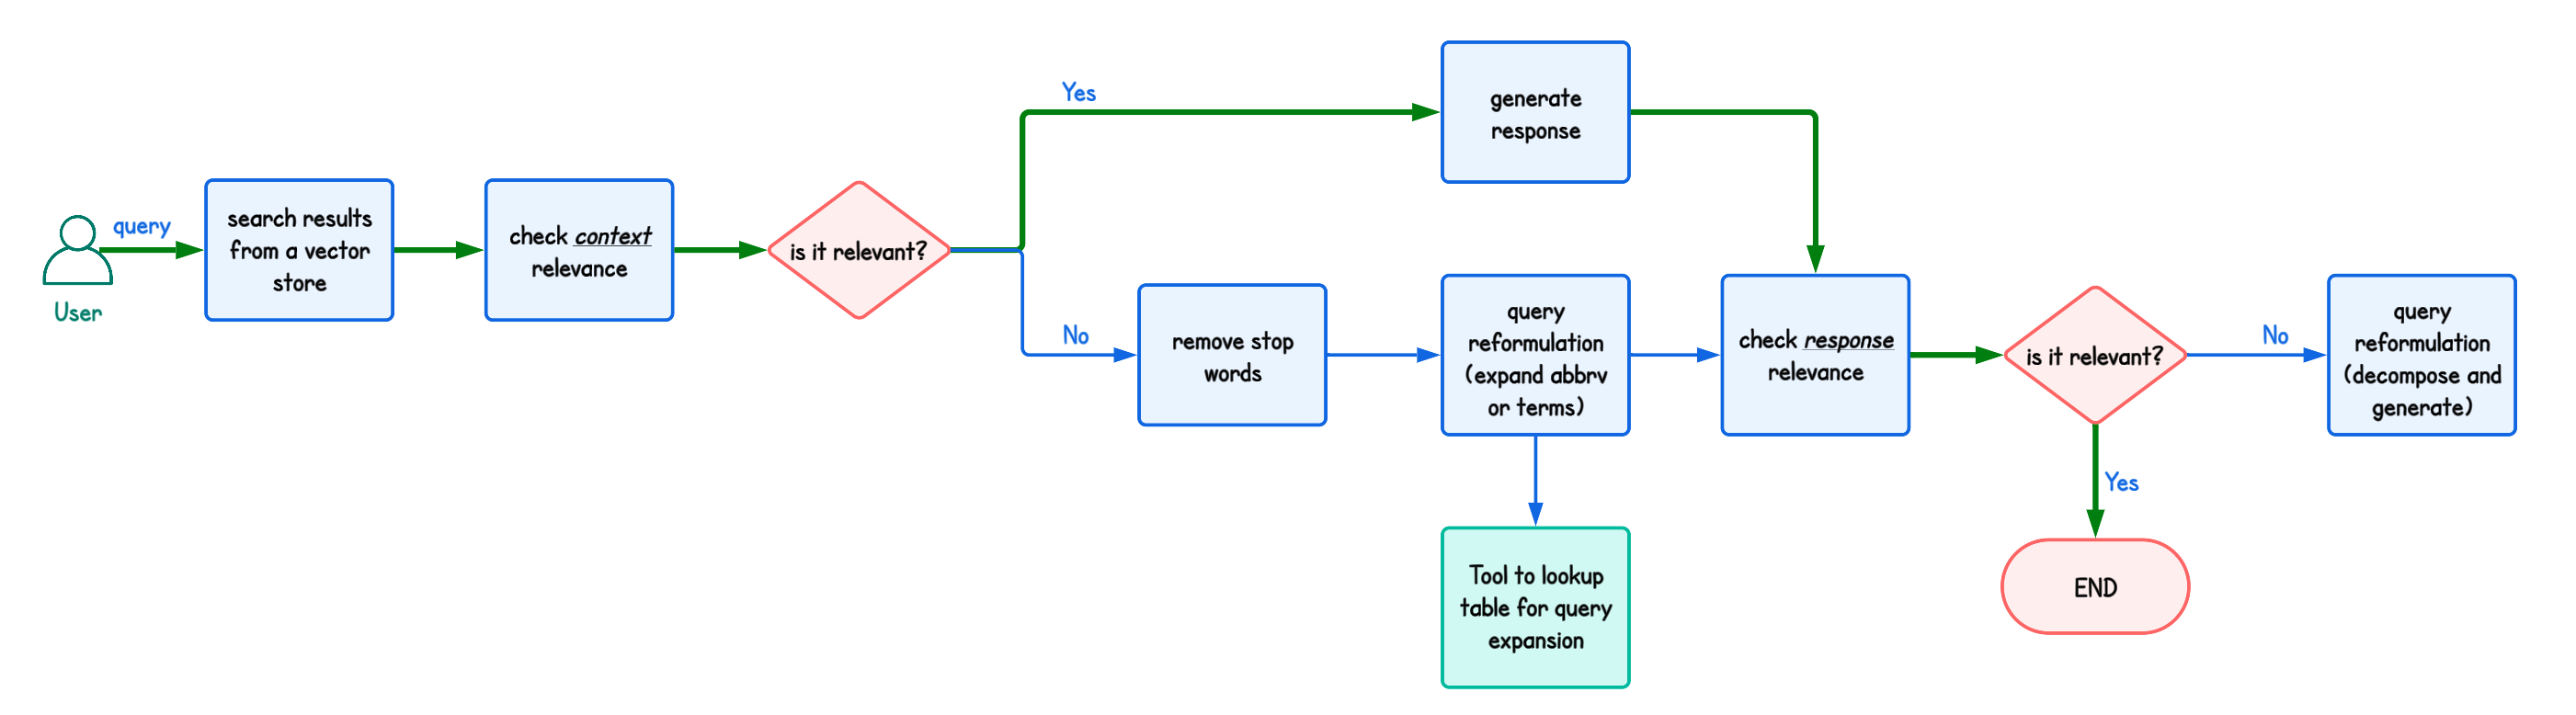

In [ ]:
# basic workflow
import pprint

inputs = {
    "checkpoint":0,
    "table_name": table_name,
    "question": "What is the fair value of HTM portfolio?"
}
async for output in graph.astream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

## Case 2: Complex Query with Decomposition

This example demonstrates query decomposition for a complex query:
1. A query about "Octank Tower" and a whistleblower scandal is submitted
2. Initial retrieval finds relevant documents about the scandal but not the tower
3. The first generated response is incomplete
4. The response evaluation detects this issue
5. The query is sent to the decompose_and_generate node
6. Query decomposition breaks down the complex query and improves the response

This shows how the system can detect and correct failures in the initial response.

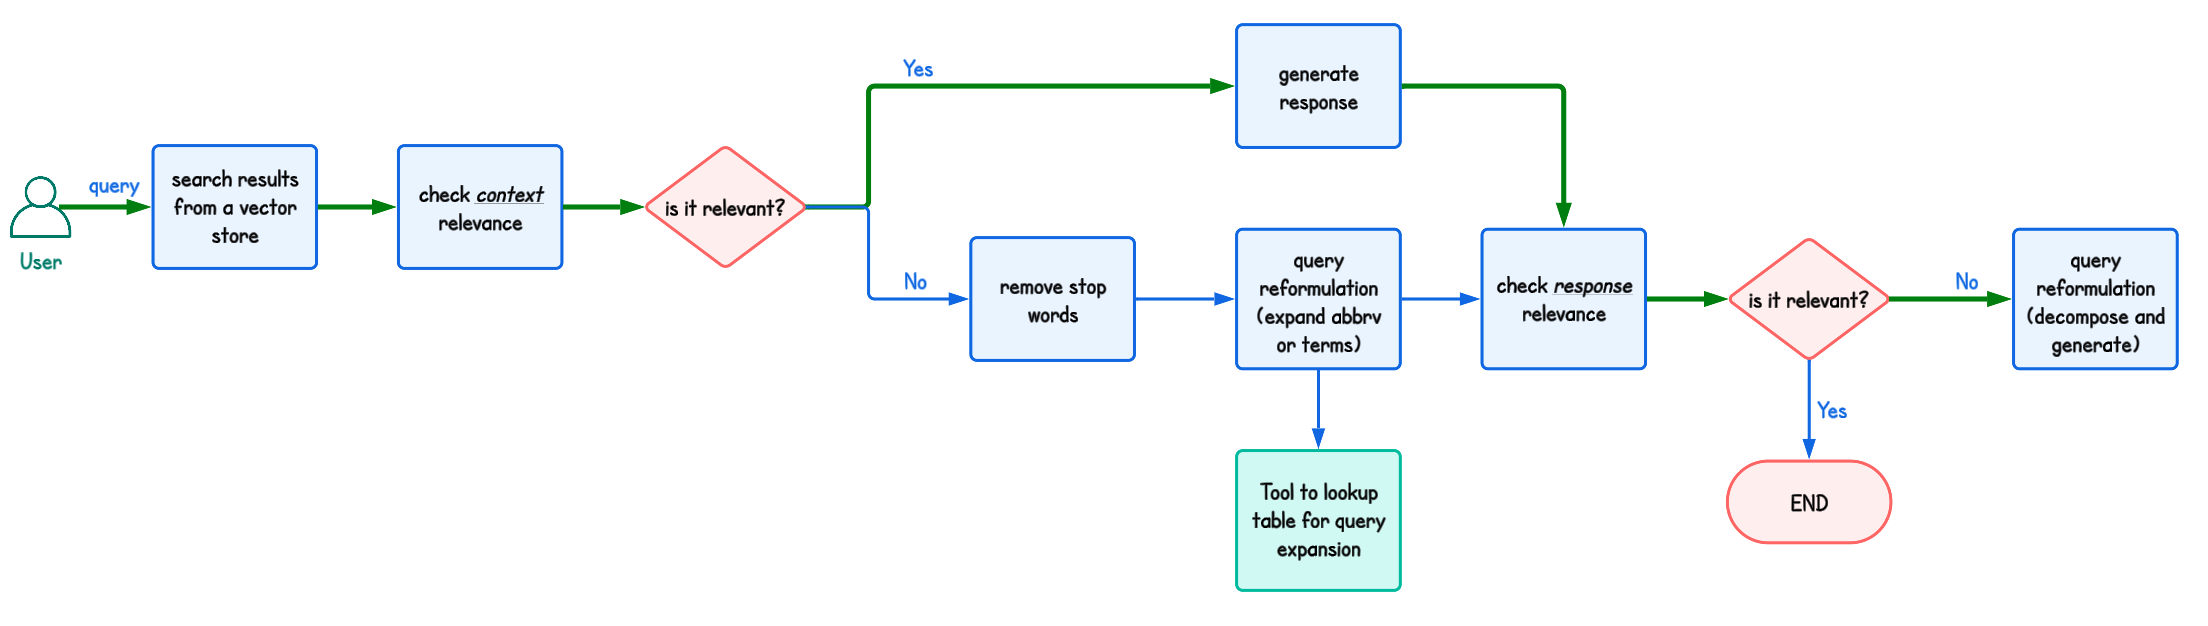

In [ ]:
# Case 2: Complex query
import pprint

inputs = {
    "checkpoint":0,
    "table_name": table_name,
    "question": "What is octank tower and how does the whistleblower scandal hurt the company and its image?"
}
async for output in graph.astream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

## Case 3: Query Expansion Workflow

This example demonstrates the query expansion path:
1. A query about "DCMs" is submitted with an acronym
2. Initial retrieval fails to find relevant documents (context_relevance_score = "no")
3. Stop words are removed to extract key terms
4. The query_expansion node looks up "DCMs" in the DynamoDB table
5. The lookup returns "Disclosure Committee Members" as the expansion
6. The query is transformed with the expanded acronym
7. Retrieval is performed with the expanded query
8. A response is successfully generated with the relevant information

This shows how the system can expand domain-specific terminology to improve retrieval.

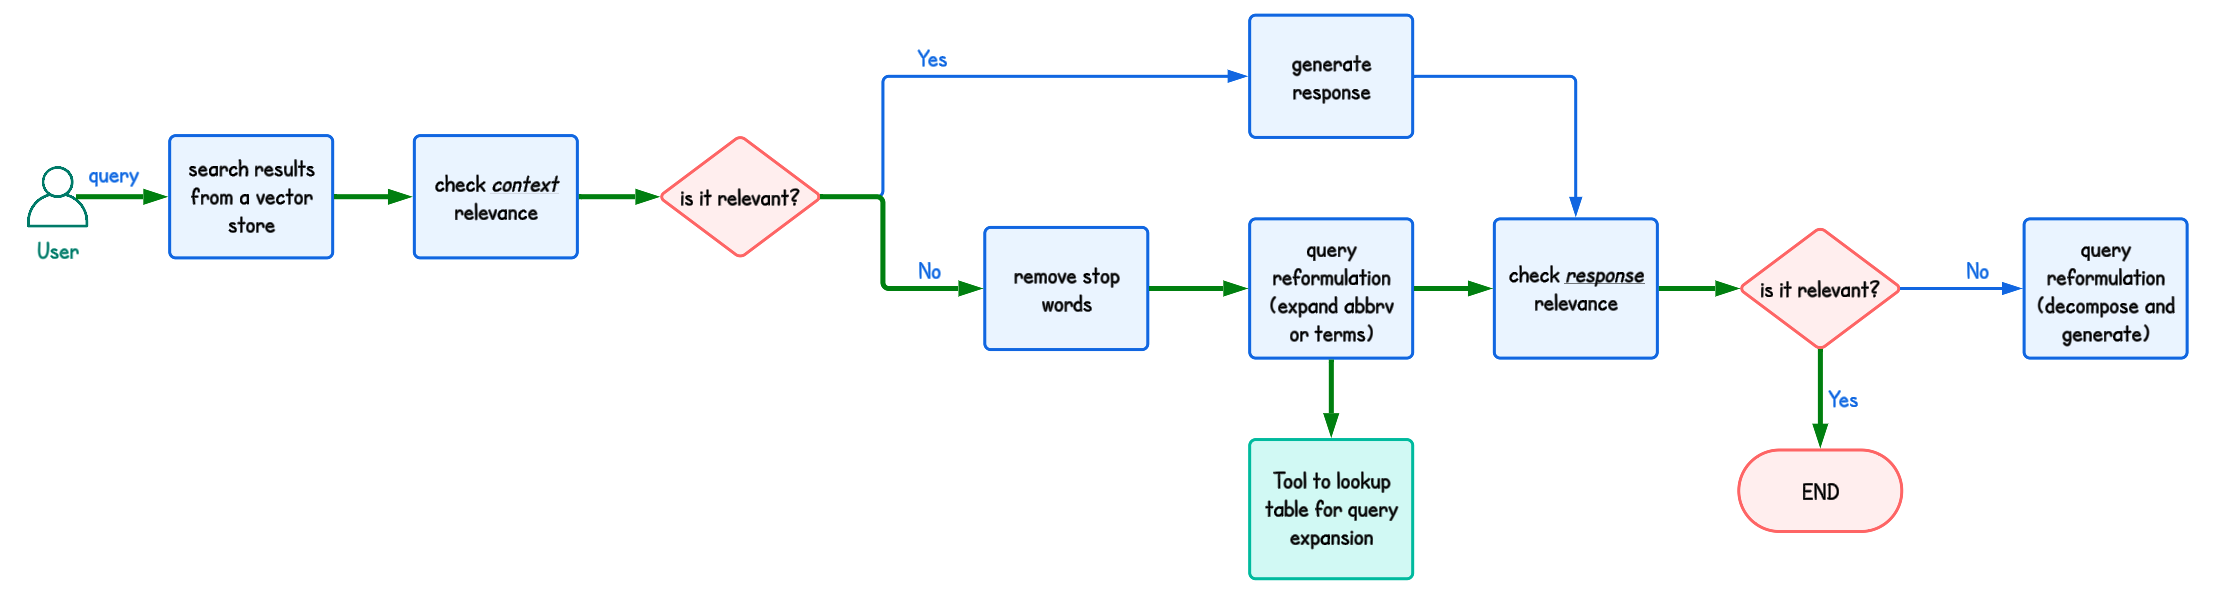

In [ ]:
import pprint

inputs = {
    "checkpoint":0,
    "table_name": table_name,
    "question": "Provide list of DCMs."
}
async for output in graph.astream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

## Case 4: Query Expansion and Decomposition Combined

This example demonstrates both query expansion and decomposition:
1. A complex query about DCMs and regional offices is submitted
2. Initial retrieval fails to find relevant documents
3. Stop words are removed and query expansion is performed for "DCMs"
4. A new query is formed with the expanded term "Disclosure Committee Members"
5. The first generated response is incomplete (only answers part of the question)
6. The decompose_and_generate node is used to improve the response
7. The final response successfully addresses both parts of the question

This case shows how the workflow can combine multiple optimization techniques for complex queries.

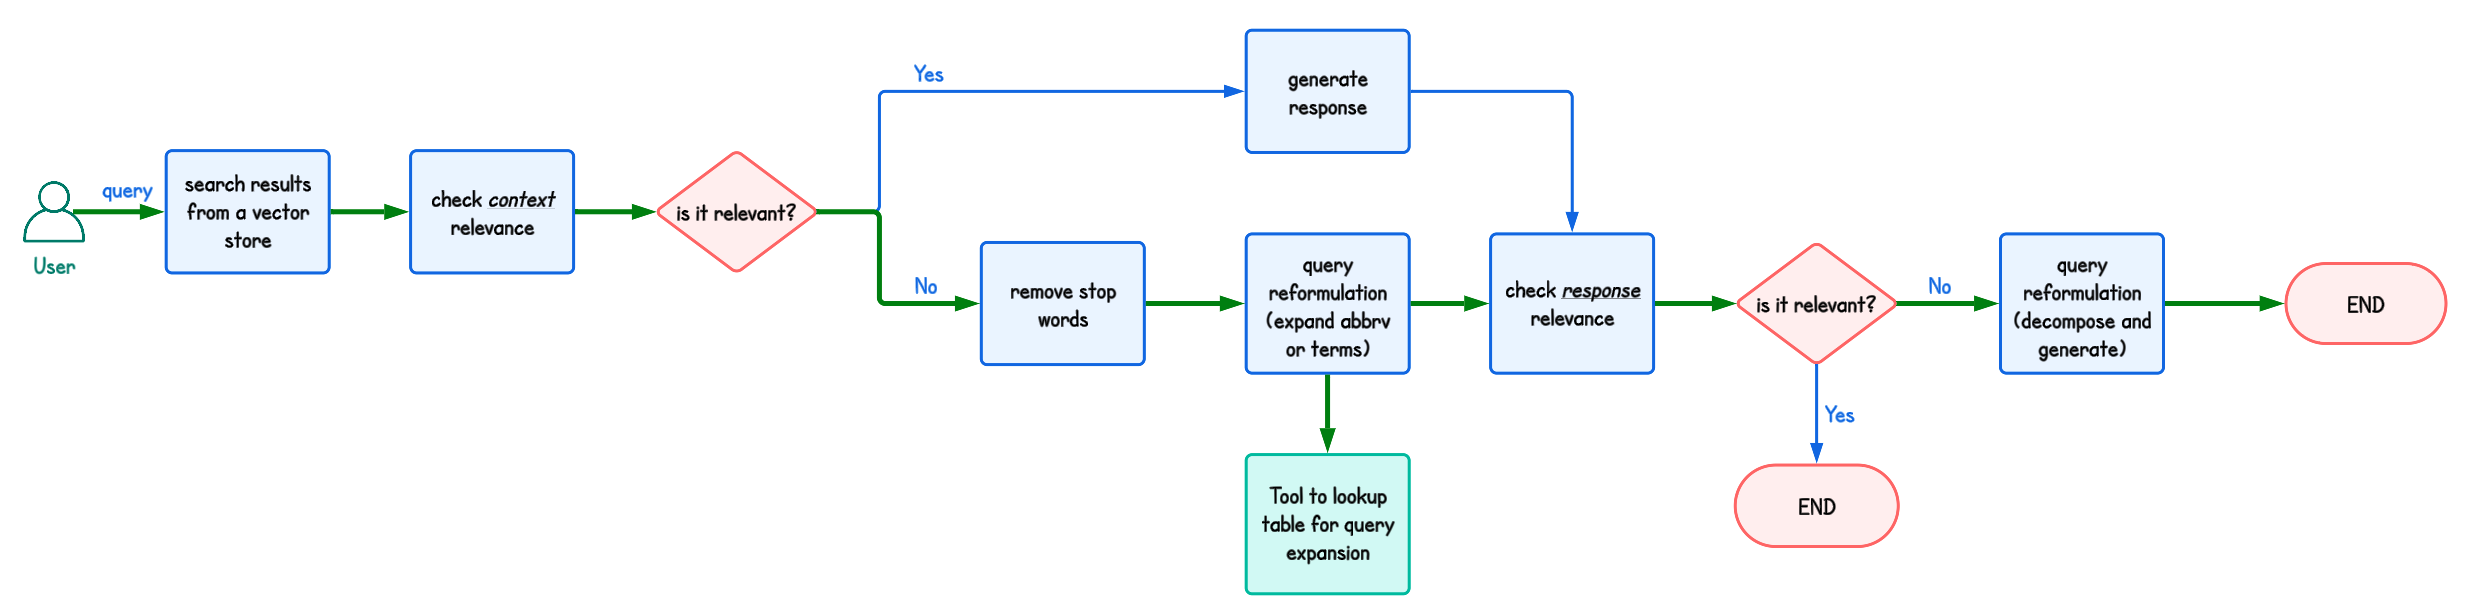

In [ ]:
import pprint

inputs = {
    "checkpoint":0,
    "table_name": table_name,
    "question": "Provide list of DCMs and how many regional offices?"
}
async for output in graph.astream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

**Note**: Please note that in some cases, your answers might be different from expected as its a sample notebook and can be optimized for evaluation on context and response relevance. 

### Clean up
### Delete Knowledge Base
Please make sure to uncomment and run the below section to delete all the resources.

In [ ]:
# delete role and policies
print("===============================Deleting Knowledge Base and associated resources==============================\n")
knowledge_base.delete_kb(delete_s3_bucket=True, delete_iam_roles_and_policies=True)

### Delete DynamoDB table

In [ ]:
# Cleanup function to delete the DynamoDB table
def delete_dynamodb_table(table_name):
    """
    Deletes a DynamoDB table with the given name.
    
    Args:
        table_name (str): The name of the DynamoDB table to delete.
    
    Returns:
        dict: The response from the DynamoDB service when deleting the table.
    """
    try:
        # Create a DynamoDB client
        dynamodb = boto3.client('dynamodb')
        
        # Delete the table
        response = dynamodb.delete_table(
            TableName=table_name
        )
        
        print(f"Table {table_name} deletion initiated. Waiting for completion...")
        
        # Create a DynamoDB resource
        dynamodb_resource = boto3.resource('dynamodb')
        
        # Wait for the table to be deleted
        table = dynamodb_resource.Table(table_name)
        table.meta.client.get_waiter('table_not_exists').wait(TableName=table_name)
        
        print(f"Table {table_name} has been successfully deleted.")
        return response
        
    except boto3.exceptions.ClientError as e:
        if e.response['Error']['Code'] == 'ResourceNotFoundException':
            print(f"Table {table_name} does not exist.")
        else:
            print(f"Error deleting table: {e}")
        return None

# To delete the table, uncomment the line below and run this cell
delete_dynamodb_table(table_name)

## Important Note!!

Please make sure to delete the `Knowledge Base and DynamoDB table`, created for running this notebook as it will incur charges. 

## End
